In [58]:
from PIL import Image
from tensorflow.keras.utils import save_img, load_img, img_to_array, array_to_img

In [11]:
test_image = '../raw_data/hilma_study/hilma_original/11110032.jpg'
''

100%|██████████████████████████████████████| 132/132 [00:00<00:00, 15214.71it/s]

DALL·E 2022-07-26 16.32.17 - By Hilma af Klint.png
DALL·E 2022-07-26 17.24.21 - By Hilma af Klint.png
DALL·E 2022-07-26 17.23.39 - By Hilma af Klint.png
DALL·E 2022-07-26 16.32.18 - By Hilma af Klint.png
DALL·E 2022-07-26 17.13.12 - By Hilma af Klint.png
DALL·E 2022-07-26 17.01.35 - By Hilma af Klint.png
DALL·E 2022-07-26 17.17.04 - By Hilma af Klint.png
DALL·E 2022-07-26 17.05.30 - By Hilma af Klint.png
DALL·E 2022-07-26 17.21.56 - By Hilma af Klint.png
DALL·E 2022-07-26 15.54.43 - By Hilma af Klint.png
DALL·E 2022-07-26 17.16.54 - By Hilma af Klint.png
DALL·E 2022-07-26 16.36.01 - By Hilma af Klint.png
DALL·E 2022-07-26 16.38.03 - By Hilma af Klint.png
DALL·E 2022-07-26 17.17.44 - By Hilma af Klint.png
DALL·E 2022-07-26 17.04.20 - By Hilma af Klint.png
DALL·E 2022-07-26 17.03.49 - By Hilma af Klint.png
DALL·E 2022-07-26 17.03.20 - By Hilma af Klint.png
DALL·E 2022-07-26 17.23.43 - By Hilma af Klint.png
DALL·E 2022-07-26 17.04.55 - By Hilma af Klint.png
DALL·E 2022-07-26 16.37.55 - By

In [59]:
def divide_img_blocks(img, n_blocks=(5, 5)):
    horizontal = np.array_split(img, n_blocks[0])
    split_img_list = []
    for row in horizontal:
        for block in np.array_split(row, n_blocks[1], axis=1):
            split_img_list.append(array_to_img(block))
    return split_img_list #np.array(splitted_img, dtype=object) #.reshape(n_blocks)

tiles = divide_img_blocks(im)

In [60]:
len(tiles)

25

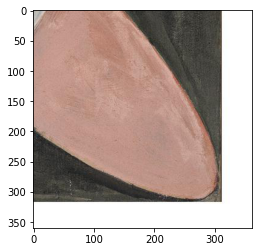

In [62]:
import matplotlib.pyplot as plt

plt.imshow(tiles[24])

In [334]:
import torch
import clip
from torch.nn import functional as F

class TileEncoder:
    
    def __init__(self, model_name):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.preprocess = clip.load(model_name, device=device)
        
    
    def divide_img_tiles(self, img, n_tiles=(5, 5)):
        horizontal = np.array_split(img, n_tiles[0])
        tiles_list = []
        for row in horizontal:
            for tile in np.array_split(row, n_tiles[1], axis=1):
                tiles_list.append(array_to_img(tile))
        return tiles_list

        
    def preprocess_tiles(self, tiles_list):
         return torch.tensor(np.stack([self.preprocess(tile).to(device) for tile in tiles_list]))
        
        
    def encode_images(self, preprocessed_tiles):
        with torch.no_grad():
            image_features = self.model.encode_image(preprocessed_tiles).float()
        return image_features
    
    def get_features(self, img):
        
        img_tiles = self.divide_img_tiles(img)

        p_img_tiles = self.preprocess_tiles(img_tiles)

        tiles_features = self.encode_images(p_img_tiles)
        
        return tiles_features, img_tiles
    
    
    def spherical_dist_loss(self, x, y):
        """from github.com/crowsonkb/k-diffusion/sample_clip_guided.py"""
        x = F.normalize(x, dim=-1)
        y = F.normalize(y, dim=-1)
        return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)
    

    def feature_distance(self, pil_img_one, pil_img_two):
    
        features_one, tiles_one = self.get_features(img_to_array(pil_img_one))
        features_two, tiles_two = self.get_features(img_to_array(pil_img_two))
        
        all_tile_combos = list(((x,y) for x in range(len(features_one)) for y in range(len(features_two))))
        
        distance_list = []
        
        for one_id, two_id in all_tile_combos:
            sph_dist = spherical_dist_loss(features_one[one_id], features_two[two_id])
            distance_list.append(sph_dist.item())
            
        sorted_combos = [(combo[0], combo[1], distance) for distance, combo in sorted(zip(distance_list, all_tile_combos), key = lambda pair: pair[0])]
        #sorted_combos = [{'x_id': combo[0], 'y_id': combo[1], 'dist' : distance} for distance, combo in sorted(zip(distance_list, all_tile_combos), key = lambda pair: pair[0])] 

        return sorted_combos, (tiles_one, tiles_two)
        

In [335]:
tile_encoder = TileEncoder("ViT-B/32") # "ViT-L/14"

In [336]:
np.array(distance_list).mean()

0.23271745598316193

In [337]:
orginal_img = Image.open('../raw_data/hilma_study/hilma_original/11110045.jpg')

In [338]:
# output_img= Image.open('../raw_data/hilma_study/hilma_dalle/DALL·E 2022-07-26 16.32.17 - By Hilma af Klint.png')

In [ ]:
folder = '../raw_data/hilma_study/hilma_dalle'

compare_distances = []
compare_tile_combos = []
tiles_list = []

print("Number of comparisons: ", len(os.listdir(f"{folder}")))

for file in tqdm(os.listdir(f"{folder}")):
    if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.webp') or file.endswith('.png'):
        sorted_combos, tiles = tile_encoder.feature_distance(orginal_img, Image.open(f'{folder}/{file}'))
        compare_tile_combos.append(sorted_combos)
        compare_distances.append([results_tup[2] for results_tup in sorted_combos])
        tiles_list.append(tiles)
        
        

Number of comparisons:  132


 23%|█████████▌                                | 30/132 [04:43<58:44, 34.55s/it]

In [342]:
compare_tile_combos

[[(19, 4, 0.09290209412574768),
  (5, 4, 0.09445130825042725),
  (6, 14, 0.09907061606645584),
  (18, 4, 0.10349640995264053),
  (19, 19, 0.10420817881822586),
  (1, 4, 0.10636991262435913),
  (19, 14, 0.10704975575208664),
  (12, 14, 0.10719797760248184),
  (18, 19, 0.1086668148636818),
  (5, 19, 0.10910215973854065),
  (6, 19, 0.11081171780824661),
  (23, 4, 0.11131145805120468),
  (12, 4, 0.11142794787883759),
  (6, 18, 0.11279810220003128),
  (12, 19, 0.11326823383569717),
  (18, 14, 0.11376380175352097),
  (6, 4, 0.11477360874414444),
  (18, 18, 0.1151333749294281),
  (5, 14, 0.11541371047496796),
  (23, 14, 0.11619370430707932),
  (0, 4, 0.12134560942649841),
  (8, 4, 0.12223471701145172),
  (19, 18, 0.12242432683706284),
  (13, 4, 0.1236794963479042),
  (8, 3, 0.12390168756246567),
  (23, 19, 0.1249934583902359),
  (1, 19, 0.12559667229652405),
  (8, 19, 0.12605653703212738),
  (12, 18, 0.12643538415431976),
  (18, 21, 0.1274697333574295),
  (5, 18, 0.1285126954317093),
  (6, 9,

In [ ]:
np.array(compare_distances).shape

In [167]:
# from sklearn.metrics import mean_squared_error, 

# def norm_mse_loss(x, y):
#     x = F.normalize(x, dim=-1)
#     y = F.normalize(y, dim=-1)
#     return mean_squared_error(x, y)

In [292]:
org_match = set([combo[0] for combo in sorted_combos[:5]])
output_match = set([combo[1] for combo in sorted_combos[:5]])

/var/folders/_n/rrz6mzy13l71h2mg878ykrv80000gn/T/ipykernel_5021/1585114088.py:11: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=None, wspace=0.03, hspace=0.03)


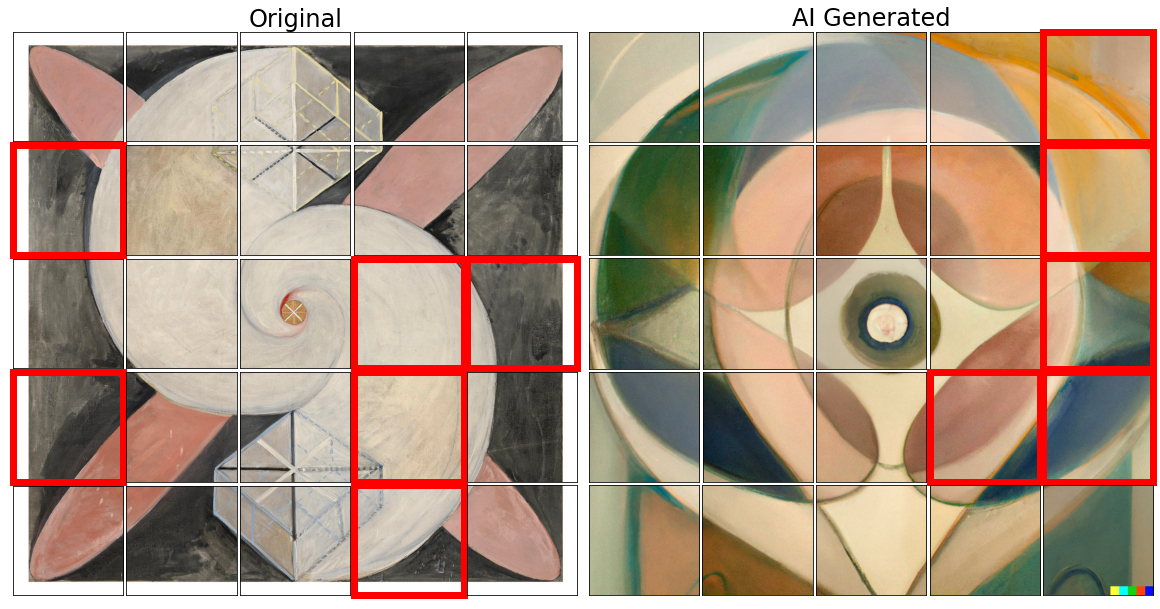

In [293]:
def plot_tiles(org_tiles, output_tiles, org_highlight_idx = None, output_highlight_idx = None):
    fig = plt.figure(constrained_layout=True, figsize = (16, 9))

    subfigs = fig.subfigures(1, 2)

    for subfig, img_tiles, title, highlight_ids in zip(subfigs.flat, 
                                               [org_tiles, output_tiles], 
                                               ['Original', 'AI Generated'], 
                                               [org_highlight_idx, output_highlight_idx]):
        axes = subfig.subplots(5, 5)
        plt.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=None, wspace=0.03, hspace=0.03)
        for idx, ax in enumerate(axes.flat):
            if idx == 2:
                ax.set_title(f'{title}', fontsize = 24)
            ax.imshow(img_tiles[idx])
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            if highlight_ids:
                if type(highlight_ids) == int: 
                    highlight_ids = [highlight_ids] # convert to list if only one number
                if idx in highlight_ids:
                    plt.setp(ax.spines.values(), color='red', linewidth=7)
                
plot_tiles(org_tiles, output_tiles, org_highlight_idx = org_match, output_highlight_idx = output_match)

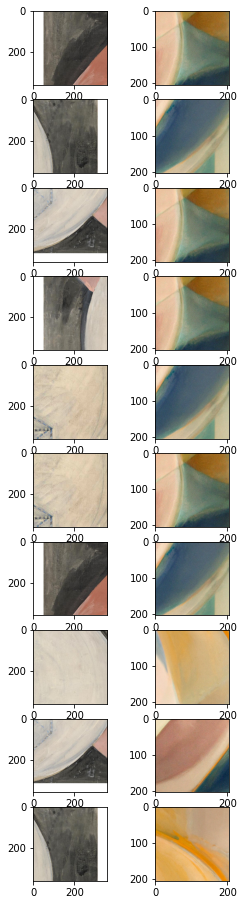

In [201]:
def plot_diff_tiles(org_tiles, output_tiles, combos):
    fig, axes = plt.subplots(10, 2, figsize = (4, 16))

    for idx, combo in enumerate(combos):
        axes[idx, 0].imshow(org_tiles[combo[0]])
        axes[idx, 1].imshow(output_tiles[combo[1]])
        
plot_diff_tiles(org_tiles, output_tiles, sorted_combos[:10])

In [56]:
from hashlib import md5
from tqdm import tqdm
import os

def remove_duplicates_in_folder(folder, destination_folder):
    hash_list = []
    for file in tqdm(os.listdir(f"{folder}")):
        if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.webp') or file.endswith('.png'):
            img = img_to_array(load_img(f'{folder}/{file}'))
            img_hash = md5(img).hexdigest()
            if img_hash not in hash_list:
                hash_list.append(img_hash)
                save_img(f'{destination_folder}/{file}', img)
    old_len = len(os.listdir(f'{folder}'))
    new_len = len(os.listdir(f'{destination_folder}'))
    print(f'Before: {old_len} images')
    print(f'After: {new_len} images')

# !mkdir ../raw_data/hilma_study_nodups

# remove_duplicates_in_folder(folder = '../raw_data/hilma_study', 
#                             destination_folder = '../raw_data/hilma_study_nodups')